<a id='sec0'></a>
# UserType Classification without Resampling
- Test with Multinomial Naive Bayes, Decision Tree, and Random Forest classifiers
- Compare their performance by various metrics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split#, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from collections import Counter

import my_scoring_functions as msf

%matplotlib inline

# Setting up Data (This time tried to label subscriber as 0)

In [2]:
d2013 = pd.read_csv('../data/for_predictions/2013_membership_pred.csv')
d2014 = pd.read_csv('../data/for_predictions/2014_membership_pred.csv')
d2015 = pd.read_csv('../data/for_predictions/2015_membership_pred.csv')
d2016 = pd.read_csv('../data/for_predictions/2016_membership_pred.csv')
d2017 = pd.read_csv('../data/for_predictions/2017_membership_pred.csv')

In [6]:
# Create dataset for the  classification
data = pd.concat([d2013, d2014, d2015, d2016, d2017], axis=0)
data = data.dropna()
del data['gender']

In [7]:
data.columns

Index(['tripduration', 'start station latitude', 'start station longitude',
       'end station latitude', 'end station longitude', 'start_year',
       'start_month', 'start_day', 'start_hour', 'start_dayofweek',
       'usertype'],
      dtype='object')

In [8]:
data.head()

,tripduration,start station latitude,start station longitude,end station latitude,end station longitude,start_year,start_month,start_day,start_hour,start_dayofweek,usertype
0,634,40.753231,-73.970325,40.732219,-73.981656,2013,7,1,0,0,Customer
1,1547,40.749718,-74.002950,40.746745,-74.007756,2013,7,1,0,0,Customer
2,178,40.730287,-73.990765,40.730473,-73.986724,2013,7,1,0,0,Subscriber
3,1580,40.718939,-73.992663,40.769155,-73.981918,2013,7,1,0,0,Customer
4,757,40.734927,-73.992005,40.720664,-73.985180,2013,7,1,0,0,Subscriber


In [9]:
data.describe().round(0)

,tripduration,start station latitude,start station longitude,end station latitude,end station longitude,start_year,start_month,start_day,start_hour,start_dayofweek
count,39096233.0,39096233.0,39096233.0,39096233.0,39096233.0,39096233.0,39096233.0,39096233.0,39096233.0,39096233.0
mean,920.0,41.0,-74.0,41.0,-74.0,2015.0,7.0,16.0,14.0,3.0
std,7616.0,0.0,0.0,0.0,0.0,1.0,3.0,9.0,5.0,2.0
min,60.0,0.0,-74.0,0.0,-74.0,2013.0,1.0,1.0,0.0,0.0
25%,385.0,41.0,-74.0,41.0,-74.0,2014.0,5.0,8.0,10.0,1.0
50%,623.0,41.0,-74.0,41.0,-74.0,2015.0,8.0,16.0,15.0,3.0
75%,1042.0,41.0,-74.0,41.0,-74.0,2016.0,10.0,23.0,18.0,4.0
max,8933552.0,41.0,0.0,41.0,0.0,2017.0,12.0,31.0,23.0,6.0


In [10]:
# Store name of the features for later use
feature_labels = data.columns[:-1]

In [11]:
# Create X and y for sklearn (non-subscribers will be given class=1)
X = data[data.columns[:-1]].astype(np.float)
y = (data['usertype'] == 'Customer').values.astype(np.int)

In [12]:
# Clear memory
data = None

<b>Class frequency in the original dataset</b>

In [13]:
print('==== Original Dataset ====')
total_number_rides = len(y)
total_number_subscribers = Counter(y)[0]
total_number_nonsubscribers = Counter(y)[1]
subs_perc = 100*total_number_subscribers / total_number_rides
nonsubs_perc = 100*total_number_nonsubscribers / total_number_rides
original_stats = {'total': total_number_rides, 
                              'numbers': [total_number_subscribers, total_number_nonsubscribers],
                              'percentages': [subs_perc, nonsubs_perc]}
print('Total number of Rides: %d' % total_number_rides)
print('Total number of Rides by Subscribers: %d (%.2f%% of total rides)' % (total_number_subscribers, subs_perc))
print('Total number of Rides by Non-subscribers: %d (%.2f%% of total rides)' % (total_number_nonsubscribers, nonsubs_perc))

==== Original Dataset ====
Total number of Rides: 39096233
Total number of Rides by Subscribers: 34723683 (88.82% of total rides)
Total number of Rides by Non-subscribers: 4372550 (11.18% of total rides)


# Initial classification with NaiveBayes, DecisionTree, and RandomForest

In [14]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [15]:
%%time
# Train Naive Bayes
Xnbc_train = X_train.copy()
Xnbc_test = X_test.copy()
Xnbc_train.iloc[:, [2, 4]] = np.abs(Xnbc_train.iloc[:, [2, 4]])
Xnbc_test.iloc[:, [2, 4]] = np.abs(Xnbc_test.iloc[:, [2, 4]])

nbc = MultinomialNB()
nbc.fit(Xnbc_train, y_train)

CPU times: user 6.76 s, sys: 6.4 s, total: 13.2 s
Wall time: 15.4 s


In [16]:
%%time
# Train Decision Tree
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

CPU times: user 10min 37s, sys: 2.41 s, total: 10min 39s
Wall time: 10min 40s


In [17]:
%%time
# Train Random Forest
rfc = RandomForestClassifier(n_jobs=4)
rfc.fit(X_train, y_train)

CPU times: user 52min 32s, sys: 32.3 s, total: 53min 4s
Wall time: 15min 44s


In [18]:
%%time
# Test Naive Bayes
nbc_results = msf.score_clf2(nbc, Xnbc_test, y_test, X_train=Xnbc_train, y_train=y_train)

CPU times: user 1min 52s, sys: 27.1 s, total: 2min 19s
Wall time: 2min 8s


In [19]:
%%time
# Test Decision Tree
dtc_results = msf.score_clf2(dtc, X_test, y_test, X_train=X_train, y_train=y_train)

CPU times: user 2min 8s, sys: 18.7 s, total: 2min 26s
Wall time: 3min 15s


In [20]:
%%time
# Test Random Forest
rfc_results = msf.score_clf2(rfc, X_test, y_test, X_train=X_train, y_train=y_train)

CPU times: user 13min 42s, sys: 34.2 s, total: 14min 17s
Wall time: 5min 19s


==== Naive Bayes Metrics on Test Set ====
Accuracy: 0.818655
Precision: 0.307429
Recall: 0.497085
F-Score: 0.379903
Brier Score: 0.180811
Average Precision Score: 0.425955
Confusion Matrix:  [[11933801  1957051]
 [  878915   868727]]
==== Naive Bayes Metrics on Train Set ====
Accuracy: 0.818597
Precision: 0.307728
Recall: 0.497054
F-Score: 0.380121
Brier Score: 0.180879
Average Precision Score: 0.426036
Confusion Matrix:  [[17897706  2935125]
 [ 1320188  1304720]]


==== Decision Tree Metrics on Test Set ====
Accuracy: 0.880348
Precision: 0.468571
Recall: 0.526915
F-Score: 0.496034
Brier Score: 0.119649
Average Precision Score: 0.524185
Confusion Matrix:  [[12846463  1044389]
 [  826783   920859]]
==== Decision Tree Metrics on Train Set ====
Accuracy: 0.999963
Precision: 0.999999
Recall: 0.999674
F-Score: 0.999836
Brier Score: 0.000018
Average Precision Score: 1.000000
Confusion Matrix:  [[20832829        2]
 [     857  2624051]]
--------------- Feature Importances ---------------
 1) 

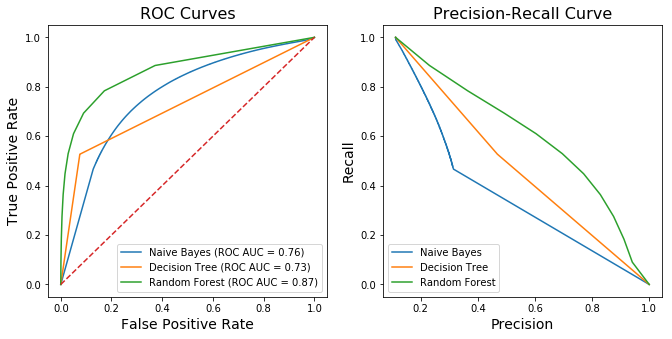

In [21]:
# print and plot test results with cutsom functions (see my_scoring_functions.py)
clf_names = ['Naive Bayes', 'Decision Tree', 'Random Forest']
results = [nbc_results, dtc_results, rfc_results]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))

for i in range(len(clf_names)):
    if clf_names[i] == 'Naive Bayes':
        msf.print_clf_scores2(results[i], trainset=True, clf_name=clf_names[i])
    else:
        msf.print_clf_scores2(results[i], trainset=True, clf_name=clf_names[i], feature_labels=feature_labels)
    print('\n')
                               
    fpr = results[i]['scores']['roc_curve'][0]
    tpr = results[i]['scores']['roc_curve'][1]
    roc_auc = results[i]['scores']['roc_auc']
    ax1.plot(fpr, tpr, ls='-', label='%s (ROC AUC = %0.2f)' % (clf_names[i], roc_auc))
    
    # Precision-Recall Curve to be implemented here
    prec = results[i]['scores']['pr_curve'][0]
    rec = results[i]['scores']['pr_curve'][1]      
    ax2.plot(prec, rec, label='%s' % clf_names[i])

x = np.linspace(0, 1, 10)
y = np.linspace(0, 1, 10)                               
ax1.plot(x, y, ls='--')
ax1.set_title('ROC Curves', fontsize=16)
ax1.set_xlabel('False Positive Rate', fontsize=14)
ax1.set_ylabel('True Positive Rate', fontsize=14)
ax1.legend(loc='lower right')

ax2.set_title('Precision-Recall Curve', fontsize=16)
ax2.set_xlabel('Precision', fontsize=14)
ax2.set_ylabel('Recall', fontsize=14)
ax2.legend(loc='lower left')                             

In [22]:
# Create a table fo summarize the results
data_summary = [nbc_results['scores_train'], nbc_results['scores'], 
                                dtc_results['scores_train'], dtc_results['scores'], 
                                rfc_results['scores_train'], rfc_results['scores']]
summary = pd.DataFrame(data_summary)
summary['Classifier'] = ['Multinomial Naive Bayes', 'Multinomial Naive Bayes',
                                           'Decision Tree', 'Decision Tree',
                                           'Rando Forest', 'Rando Forest']
summary['dataset type'] = ['train', 'test', 'train', 'test', 'train', 'test',]
summary = summary[['Classifier', 'dataset type', 'accuracy', 'precision', 'recall', 'f1', 
                                               'average_precision_score', 'brier']]

In [23]:
# Print the table
print('==== Performance of Classifiers ====')
summary

==== Performance of Classifiers ====


,Classifier,dataset type,accuracy,precision,recall,f1,average_precision_score,brier
0,Multinomial Naive Bayes,train,0.818597,0.307728,0.497054,0.380121,0.426036,0.180879
1,Multinomial Naive Bayes,test,0.818655,0.307429,0.497085,0.379903,0.425955,0.180811
2,Decision Tree,train,0.999963,0.999999,0.999674,0.999836,1.000000,0.000018
3,Decision Tree,test,0.880348,0.468571,0.526915,0.496034,0.524185,0.119649
4,Rando Forest,train,0.991417,0.996929,0.926152,0.960238,0.998263,0.011373
5,Rando Forest,test,0.923392,0.770295,0.448119,0.566612,0.645064,0.062643
